In [3]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential, load_model

# 1) TRAIN DATA (OPTIONAL)

## Load Data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
h, w = X_train.shape[1:]

## Preprocess Data

### reshape for CNN

In [6]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
X_train.shape

(60000, 28, 28, 1)

### Scale to range(0, 1)

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Reverse background and foreground of image

In [9]:
X_train = 1 - X_train
X_test = 1 - X_test

### OneHot to y

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

<IPython.core.display.Javascript object>


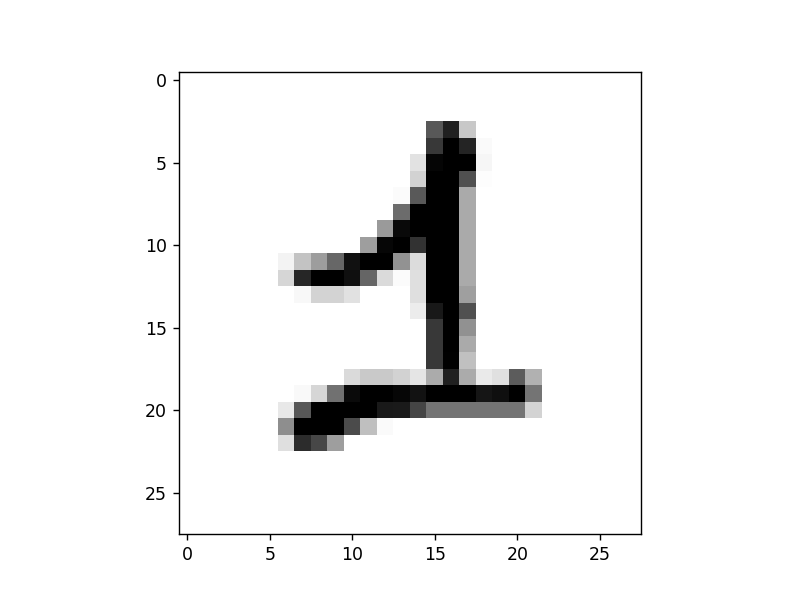

In [11]:
# show an image
plt.figure()
index = 24
plt.imshow(X_train[index, :, :, 0], "gray")

## Create and Train Model

### Create and Compile the model

In [16]:
model = Sequential()

# layer 1
model.add(Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same", input_shape=(h, w, 1)))
model.add(Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model.add(MaxPooling2D((2, 2)))

# layer 2
model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model.add(MaxPooling2D((2, 2)))

# flatten
model.add(Flatten())
          
# dense layer
model.add(Dense(200, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(10, activation="softmax"))
          
# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Fit the model

In [17]:
model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=2)

Epoch 1/2
1875/1875 - 18s - loss: 0.1467 - accuracy: 0.9545
Epoch 2/2
1875/1875 - 17s - loss: 0.0431 - accuracy: 0.9862


### Evaluate the model

In [18]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0331 - accuracy: 0.9892


[0.03313884139060974, 0.9891999959945679]

### save model

In [39]:
#model.save("data/digit_model.h5")

# 2) LOAD MODEL and TEST IT

## Load Model

In [5]:
model = load_model("data/digit_model.h5")

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

## Create Application

### Run these cells to define functions

In [7]:
def load_image(image_name):
    try:
        image = cv2.imread(image_name)
    except:
        print("Image can not be opened!")
        return None
    return image

In [8]:
def preprocess_image(image):
    # to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # threshold
    ret, thresh = cv2.threshold(gray.copy(), 100, 255, cv2.THRESH_BINARY_INV)

    return thresh

In [9]:
def find_contour_images(image):
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_images = []
    
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        
        # size filter
        if w < 10 and h < 10:
            continue
        
        # crop digit
        digit = image[y:y+h, x:x+w]
        
        # resize digit to 18x18
        #resized = cv2.resize(digit, (18, 18))
        resized = cv2.resize(digit, (18, 18), interpolation=cv2.INTER_AREA)
        
        # add padding
        padded = cv2.copyMakeBorder(resized, 5, 5, 5, 5, cv2.BORDER_CONSTANT, 0)
        
        # scale images
        padded = padded / 255.0
        
        # negate image
        padded = 1 - padded
        
        contour_images.append(padded)
    
    return contour_images

In [10]:
def predict_contour_images(model, contour_images):
    preds = []
    confs = []
    
    for image in contour_images:
        probs = np.squeeze(model.predict(image.reshape(1, 28, 28, 1)))
        pred = probs.argmax()
        conf = probs.max()
        preds.append(pred)
        confs.append(conf)
    
    return preds, confs

In [11]:
def predict_image(model, image):
    probs = np.squeeze(model.predict(image.reshape(1, 28, 28, 1)))
    pred = probs.argmax()
    conf = probs.max()
    return pred, conf

In [12]:
def app(image_name, model):
    # load image
    image = load_image(image_name)
    
    # preprocess image
    image = preprocess_image(image)
    
    # find contours
    contour_images = find_contour_images(image)
    
    # predict contour images
    preds, confs = predict_contour_images(model, contour_images)

## Test Application

<IPython.core.display.Javascript object>


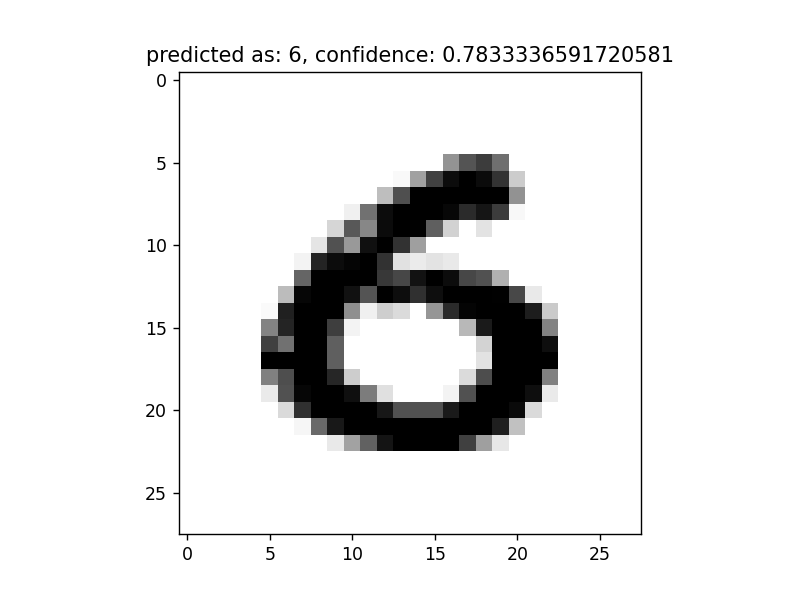

<IPython.core.display.Javascript object>


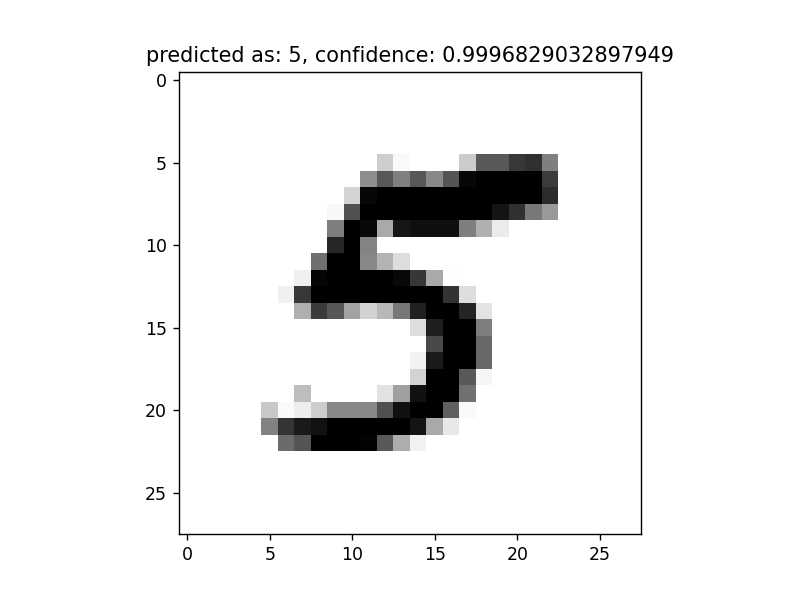

<IPython.core.display.Javascript object>


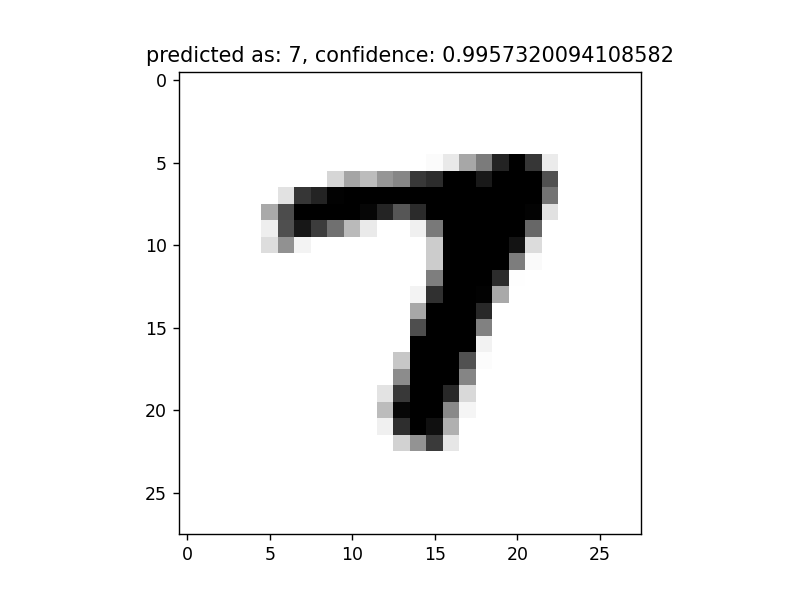

<IPython.core.display.Javascript object>


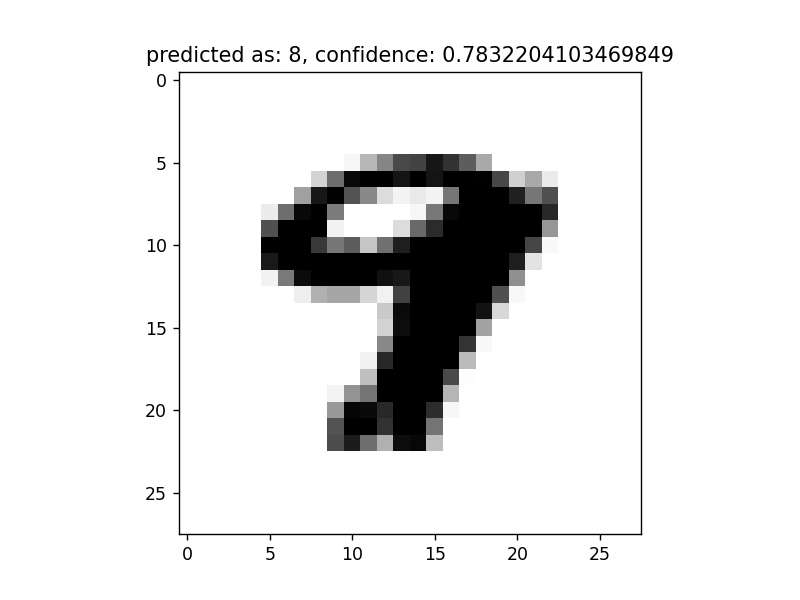

<IPython.core.display.Javascript object>


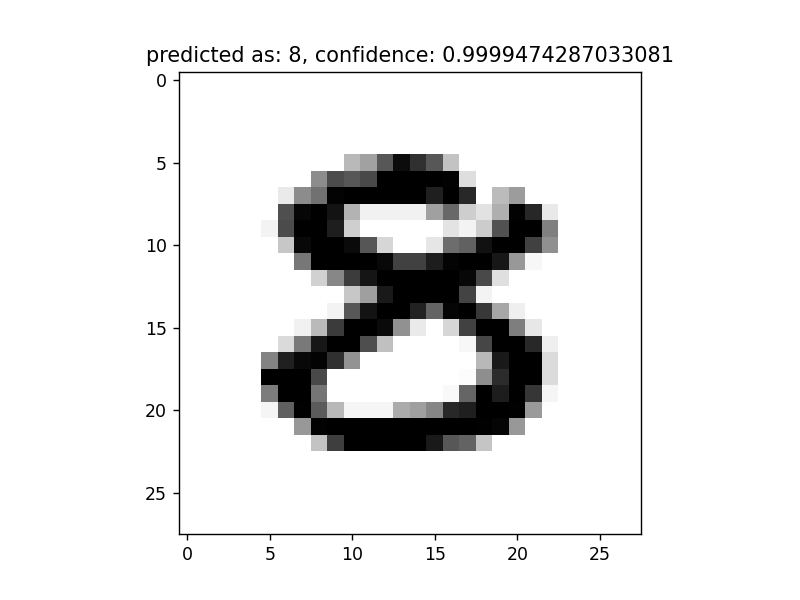

<IPython.core.display.Javascript object>


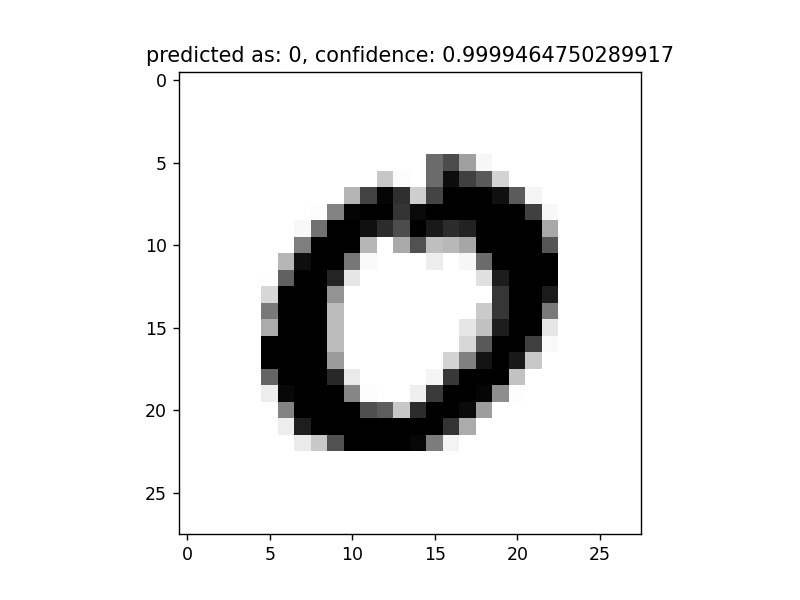

<IPython.core.display.Javascript object>


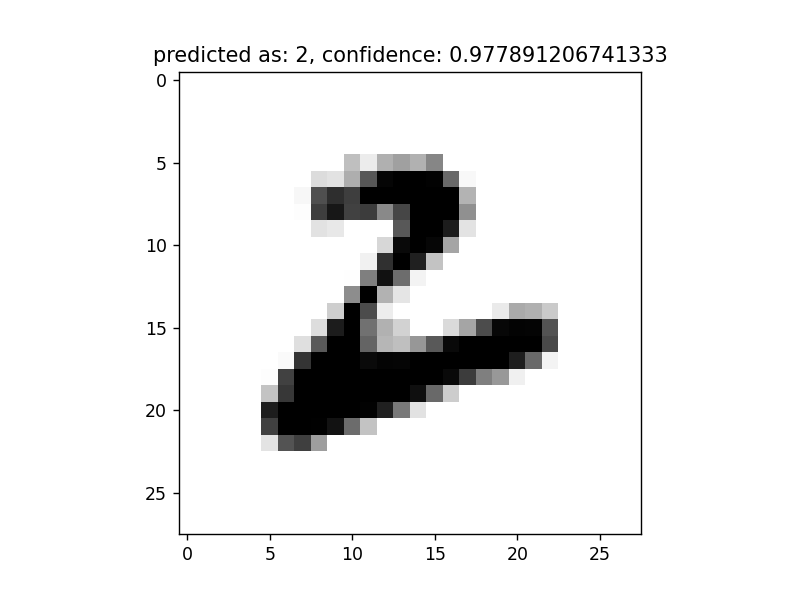

<IPython.core.display.Javascript object>


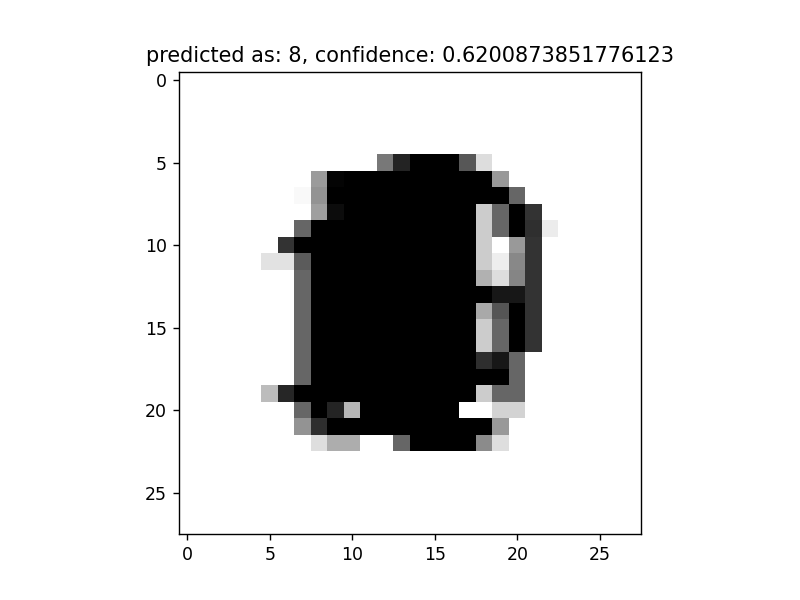

<IPython.core.display.Javascript object>


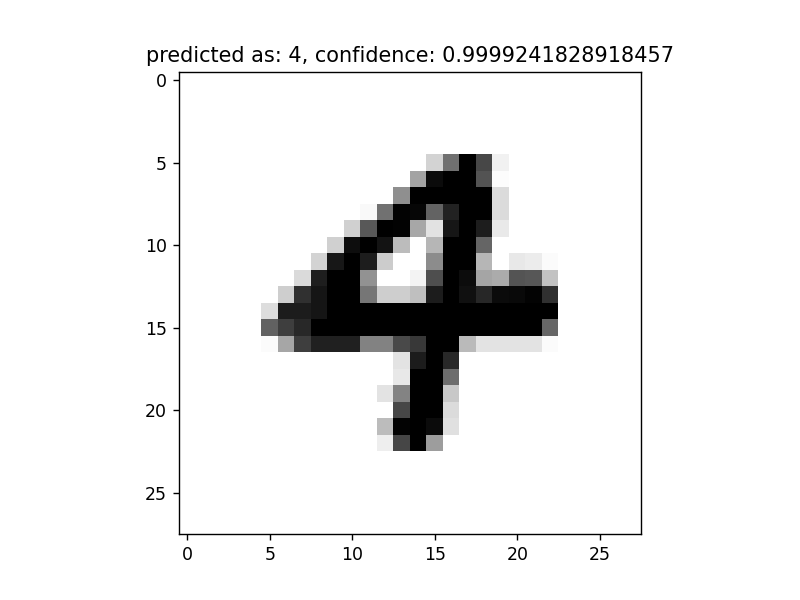

<IPython.core.display.Javascript object>


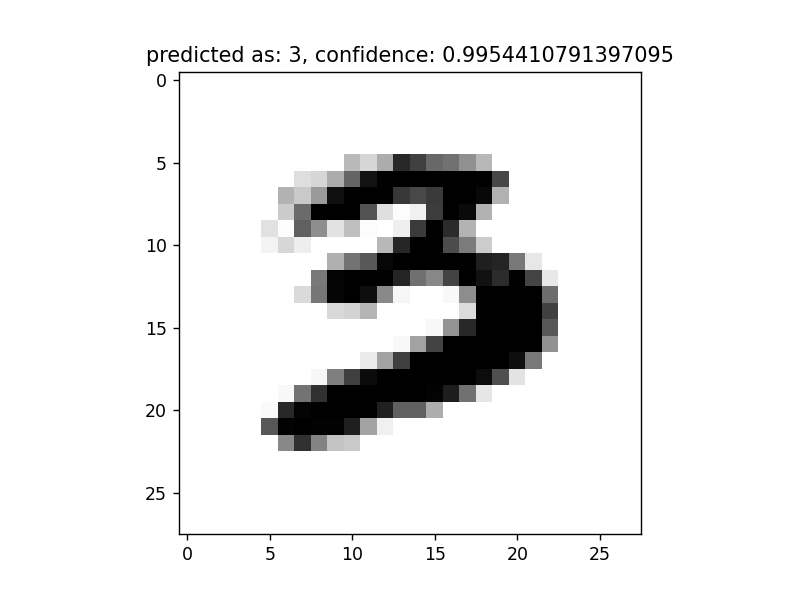

In [13]:
# load image (you can change the image name)
image = load_image("test_images/digits1.png")

# preprocess image to find contours
thresh = preprocess_image(image)

# find contours in the image
contour_images = find_contour_images(thresh)

# predict each contour
preds, confs = predict_contour_images(model, contour_images)

for i in contour_images:
    plt.figure()
    pred, conf = predict_image(model, i)
    plt.title("predicted as: {}, confidence: {}".format(pred, conf))
    plt.imshow(i, "gray")